# Downloading the Go-emotions dataset

In [1]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv &> /dev/null
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv &> /dev/null
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv &> /dev/null

# Importing the necessary modules

In [2]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

# Preprocessing the dataset

In [3]:
df1 = pd.read_csv('/content/data/full_dataset/goemotions_1.csv')
df2 = pd.read_csv('/content/data/full_dataset/goemotions_2.csv')
df3 = pd.read_csv('/content/data/full_dataset/goemotions_3.csv')

In [4]:
df_concat = pd.concat([df1, df2, df3], sort=False)
df_concat.drop(['id', 'link_id','parent_id','created_utc','rater_id','example_very_unclear'], axis=1, inplace=True)
df_concat.drop_duplicates(subset=['text', 'author', 'subreddit'], inplace=True)
df_concat.reset_index(inplace=True, drop=True)

In [5]:
len(df_concat)

58009

In [6]:
df = df_concat[['text']]

In [7]:
df['text_emotion'] = df_concat.drop(columns=['author','text','subreddit'],axis=1,inplace=False).idxmax(axis=1)

/tmp/ipython-input-1617149176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_emotion'] = df_concat.drop(columns=['author','text','subreddit'],axis=1,inplace=False).idxmax(axis=1)


In [8]:
df.head()

,text,text_emotion
0,That game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,admiration
2,"You do right, if you don't care then fuck 'em!",neutral
3,Man I love reddit.,love
4,"[NAME] was nowhere near them, he was by the Fa...",neutral


In [9]:
df['text_emotion'].value_counts()

,count
text_emotion,
neutral,15523
admiration,5707
approval,4259
annoyance,3008
gratitude,2579
amusement,2520
disapproval,2413
curiosity,2204
anger,2187


<Axes: ylabel='text_emotion'>

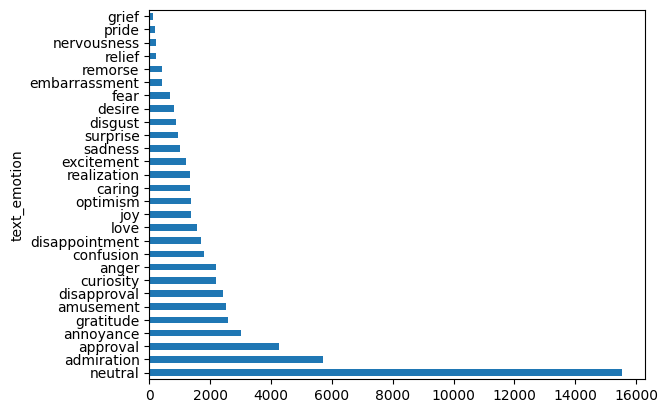

In [10]:
df['text_emotion'].value_counts().plot(kind='barh')

<Axes: ylabel='count'>

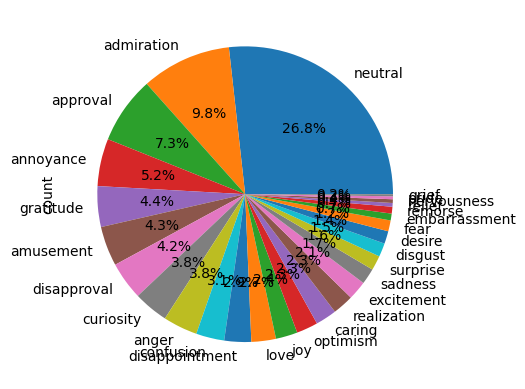

In [11]:
df['text_emotion'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [12]:
counts = df['text_emotion'].value_counts()
valid_emotions = counts[counts >= 1000].index

df = df[df['text_emotion'].isin(valid_emotions)]

In [13]:
df['text_emotion'].value_counts()

,count
text_emotion,
neutral,15523
admiration,5707
approval,4259
annoyance,3008
gratitude,2579
amusement,2520
disapproval,2413
curiosity,2204
anger,2187


In [15]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['text_emotion'])
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
df.head()

,text,text_emotion,label
0,[NAME] is the type of point guard the Magic ne...,admiration,0
1,I love how they added a camouflage hat on the ...,love,13
2,I read your story earlier today. Hun I'm here ...,caring,5
3,gO LiVe iN tHe SoMaLiAn WoOdS,neutral,14
4,The itching probably happens when your skin vi...,neutral,14


In [17]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
# Create training examples
train_examples = [
    InputExample(texts=[row['text']], label=int(row['label']))
    for _, row in train_df.iterrows()
]

In [19]:
print(f"Training samples: {len(train_examples)}")
print(f"Number of emotions: {len(label_encoder.classes_)}")

Training samples: 42459
Number of emotions: 18


# Fine-tuning the sentence transformer model

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

In [21]:
# Load model for classification
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [22]:
# Tokenize data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
train_dataset = train_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/42459 [00:00<?, ? examples/s]

In [23]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./emotion-classifier",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    save_steps=500,
    save_total_limit=2,
    logging_dir= "./logs",
    logging_steps=100,
    learning_rate=5e-5
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [24]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

In [26]:
trainer.train()

Step,Training Loss
100,2.591382
200,2.441279
300,2.297599
400,2.176352
500,2.159849
600,2.127503
700,2.073717
800,2.015498
900,1.960544
1000,1.943388


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=13270, training_loss=1.5763484170046982, metrics={'train_runtime': 3891.7127, 'train_samples_per_second': 54.551, 'train_steps_per_second': 3.41, 'total_flos': 7044952931297280.0, 'train_loss': 1.5763484170046982, 'epoch': 5.0})

In [30]:
train_history = trainer.state.log_history
losses = [log['loss'] for log in train_history if 'loss' in log]
steps = [log['step'] for log in train_history if 'loss' in log]

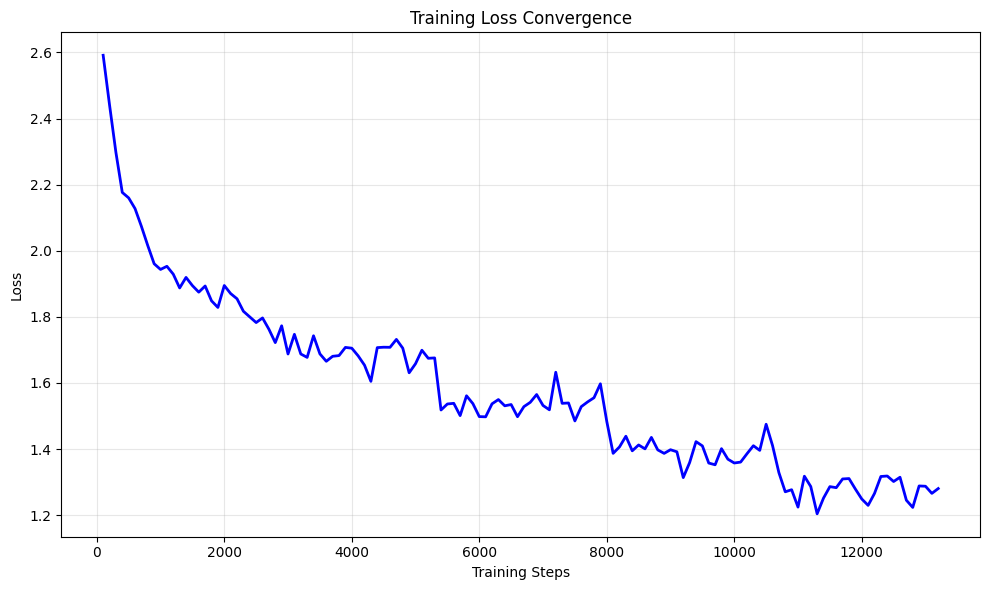

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, 'b-', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Convergence')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_convergence.png', dpi=300)
plt.show()

In [45]:
# Set device automatically
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    emotion = label_encoder.inverse_transform([prediction])[0]
    return emotion, confidence

# Test
emotion, confidence = predict_emotion("Shut up")
print(f"Emotion: {emotion}, Confidence: {confidence:.2%}")

Emotion: anger, Confidence: 75.15%


In [29]:
model.save_pretrained("emotion-classifier-model")
tokenizer.save_pretrained("emotion-classifier-model")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('emotion-classifier-model/tokenizer_config.json',
 'emotion-classifier-model/tokenizer.json')